# Run hacked AlphaFold2 on the designed paired state X's

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties
running on node: gpu4


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [2]:
# os.chdir("/global/cfs/cdirs/m3962/projects/crispy_shifty")
os.chdir("/home/pleung/projects/crispy_shifty")  # TODO

### Fix the paths
Necessary because we are on perlmutter

In [3]:
from crispy_shifty.utils.io import fix_path_prefixes

folded = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/07_fold_paired_states_Y/folded_paired_states.list",
)
new_folded = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties", # TODO change to cfs
    file=folded,
    overwrite=True,
)

https://docs.anaconda.com/anaconda/install



/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the designed paired state X's

In [4]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "07_fold_paired_states_X"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/07_fold_paired_states_Y/folded_paired_states.list",
)
# output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}") # TODO
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifties/{simulation_name}"
)  # TODO

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "3"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_paired_state_X",
    design_list_file=design_list_file,
    output_path=output_path,
    #     perlmutter_mode=True, # TODO
    nstruct=1,
    nstruct_per_task=100,  # TODO
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    sha1=None,  # TODO
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


https://docs.anaconda.com/anaconda/install

Run the following command with your desired environment active:
sbatch -a 1-62 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_X/run.sh


### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [4]:
# os.chdir("/home/pleung/projects/crispy_shifty")  # TODO

### Collect scorefiles of designed paired state Ys and concatenate
TODO change to projects dir

In [3]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import collect_score_file

simulation_name = "07_fold_paired_states_Y"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


https://docs.anaconda.com/anaconda/install



### Load resulting concatenated scorefile
TODO change to projects dir  
TODO might have to switch to a dask accelerated approach for production

In [4]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/113878 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Plot topo and scaffold_type fraction before and after

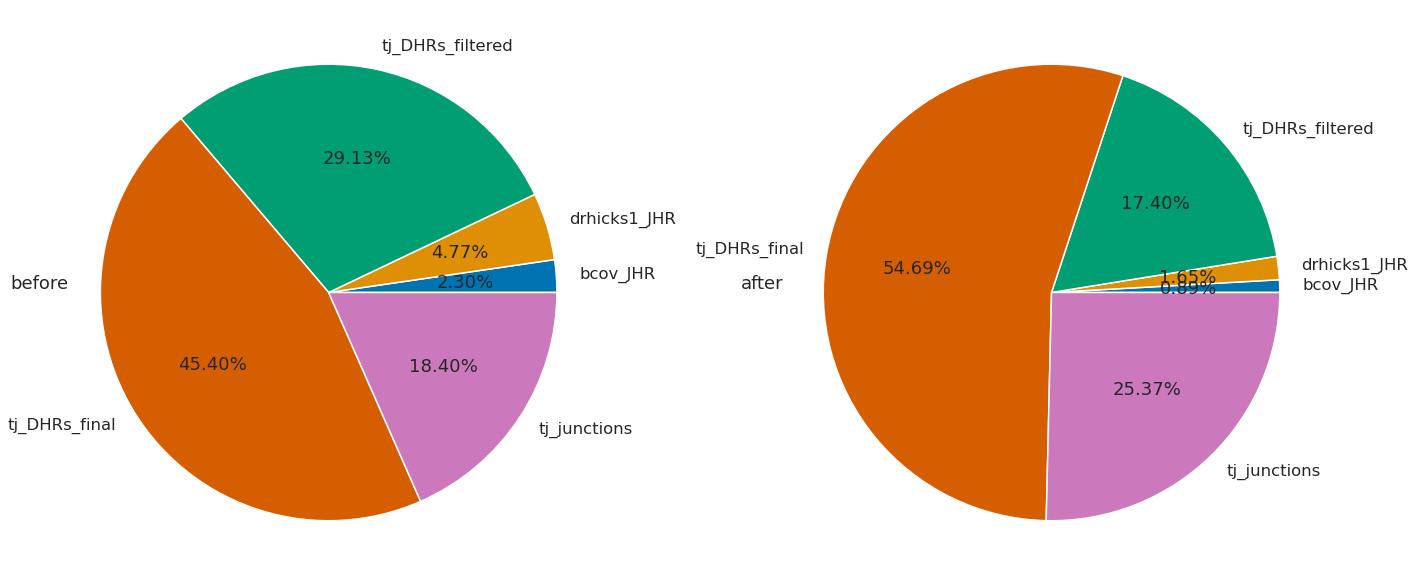

In [24]:
(
    fig,
    (ax1, ax2),
) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("before", rotation=0)
filtered.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax2.set_ylabel("after", rotation=0)

plt.savefig(os.path.join(output_path, "filtering_effect_scaffold_type.png"))

### Save a list of outputs
Sort by length

In [25]:
simulation_name = "07_fold_paired_states_Y"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "folded_paired_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/6184 [00:00<?, ?it/s]

### Prototyping blocks

test `fold_paired_state_X`

In [ ]:
%%time 
from operator import gt, lt
import pyrosetta

filter_dict = {
    "mean_plddt": (gt, 85.0),
    "rmsd_to_reference": (lt, 2.2),
    "mean_pae_interaction": (lt, 10.0),
}

rank_on = "mean_plddt"
prefix = "mpnn_seq"

pyrosetta.init()


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.folding import fold_paired_state_X

t = fold_paired_state_Y(
        None,
        **{
#             'fasta_path': '/global/cfs/cdirs/m3962/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/fastas/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.fa',
            "filter_dict": filter_dict,
            "models": [3], # TODO
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/decoys/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.pdb.bz2____/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/fastas/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.fa',
            'rank_on': rank_on,            
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
tppose.pose.scores

test `fold_paired_state_Y`

In [ ]:
%%time 
from operator import gt, lt
import pyrosetta

filter_dict = {
    "mean_plddt": (gt, 85.0),
    "rmsd_to_reference": (lt, 2.2),
    "mean_pae_interaction": (lt, 10.0),
}

rank_on = "mean_plddt"
prefix = "mpnn_seq"

pyrosetta.init()


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.folding import fold_paired_state_Y

t = fold_paired_state_Y(
        None,
        **{
#             'fasta_path': '/global/cfs/cdirs/m3962/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/fastas/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.fa',
            "filter_dict": filter_dict,
            "models": [1], # TODO
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/decoys/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.pdb.bz2____/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/fastas/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.fa',
            'prefix': prefix,
            'rank_on': rank_on,
#             'fasta_path': 'bar.fa',
#             "models": [1, 2], # TODO
#             'pdb_path': 'foo.pdb.bz2',
            
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
tppose.pose.scores